In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit

def dxdt(x, y, sigma=10):
    return sigma * (y - x)

def dydt(x, y, z, rho=28):
    return x * (rho - z) - y

def dzdt(x, y, z, beta=8/3):
    return x * y - beta * z

def RK2(x0, y0, z0, time_steps, dt, show_progress_bar = True):
    n = round(time_steps / dt)
    y = y0
    x = x0
    z = z0
    hist = []
    if show_progress_bar:
        iterator = tqdm(range(1, n+1))
    else:
        iterator = range(1, n+1)
    for i in iterator:
        hist.append([x, y, z])
        xk1 = dxdt(x, y)
        yk1 = dydt(x, y, z)
        zk1 = dzdt(x, y, z)
        xk2 = dxdt(x + xk1 * dt, y + yk1 * dt)
        yk2 = dydt(x + xk1 * dt, y + yk1 * dt, z + zk1 * dt)
        zk2 = dzdt(x + xk1 * dt, y + yk1 * dt, z + zk1 * dt)
        x += (xk1 + xk2) / 2 * dt
        y += (yk1 + yk2) / 2 * dt
        z += (zk1 + zk2) / 2 * dt
    
    return np.array(hist)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

def ly_exp_lin(t, a, lyp):
    return a + lyp * t

def ly_exp(t, a, lyp):
    return np.exp(ly_exp_lin(t, a, lyp))


In [4]:
dt = 0.0001; time_steps = 25; epsilon = 1e-9; coords0 = (2,3,-14)

def find_trajectory_distances(dt, time_steps, epsilon, coords0):
    x0, y0, z0 = coords0
    hist1 = RK2(x0, y0, z0, time_steps, dt)
    hist2 = RK2(x0, y0, z0 + epsilon, time_steps, dt)
    # dist = sqrt(dx^2 + dy^2 + dz^2)
    distances = np.sqrt((np.abs(hist1 - hist2) ** 2).sum(axis = 1))
    return hist1, hist2, distances

hist1, hist2, distances = find_trajectory_distances(dt, time_steps, epsilon, coords0)
log_dist = np.log(distances)


100%|██████████| 250000/250000 [00:00<00:00, 326860.09it/s]


In [5]:
params, cv = curve_fit(ly_exp_lin, np.linspace(0, time_steps, round(time_steps / dt)), log_dist, [epsilon, 0.8])

Text(0.5, 0, 'Z Axis')

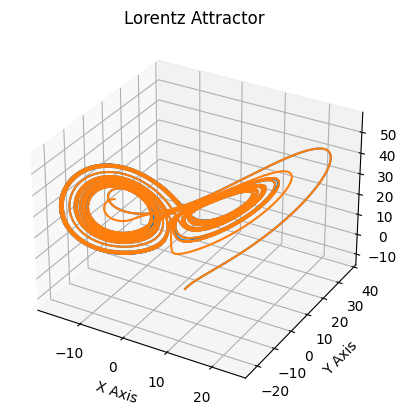

In [6]:
plt.figure(1)
ax = plt.axes(projection='3d')
ax.plot(*hist1.T)
ax.plot(*hist2.T)
ax.set_title('Lorentz Attractor')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')


Text(0.3, 0.7, '$y=0.00e^{0.94t}$')

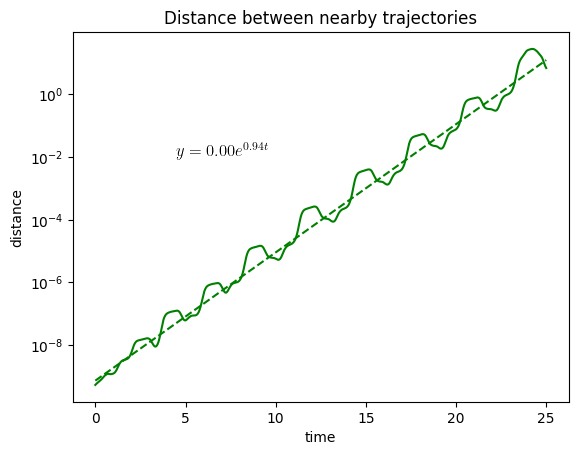

In [7]:
plt.figure(2)
ax = plt.axes()
ax.set_yscale('log')
window = 1000
ax.plot(np.linspace(0, time_steps, round(time_steps / dt)), moving_average(distances, 10000), 'g')
plt.title('Distance between nearby trajectories')
plt.xlabel('time')
plt.ylabel('distance')
xs = np.linspace(0, time_steps, round(time_steps / dt))
ys = [ly_exp(t, *params) for t in xs]
ax.plot(xs, ys, 'g--')
equation_string = f'$y={np.exp(params[0]):.2f}e^{{{params[1]:.2f}t}}$'
plt.text(0.3, 0.7, equation_string, horizontalalignment='center',
    verticalalignment='top', transform=ax.transAxes, usetex=True, fontsize=12) 

Vary initial values to see how robust this exponent is

In [18]:
values = np.arange(-5, 5, 0.5) # 20 iterations
exponents = []
starting_coords = []
for x0 in values:
    for y0 in values:
        for z0 in values:
            starting_coords.append((x0, y0, z0))
starting_coords.append((2, 3, -14))
# 20 ^ 3 = 8000 iterations
for coords0 in starting_coords:
    hist1, hist2, distances = find_trajectory_distances(dt, time_steps, epsilon, coords0)
    log_dist = np.log(distances) 
    xs = np.linspace(0, time_steps, round(time_steps / dt))
    params, cv = curve_fit(ly_exp_lin, xs, log_dist, [epsilon, 0.8])
    if not np.isfinite(np.sum(cv)):
        exponents.append(None)
        continue
    # ssr = np.sum(np.square(log_dist - (params[1] * xs + params[0]))) #sum squared regression
    # sst = np.sum(log_dist - np.mean(log_dist)) #Total sum of squares
    # r2 = 1 - (ssr / sst) #Coeff. of determination
    # if r2 < 0.5:
    #     exponents.append(None)
    #     continue
    exponents.append(params[1])
            

100%|██████████| 250000/250000 [00:00<00:00, 280722.27it/s]


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([0.43884624, 0.48884624, 0.53884624, 0.58884624, 0.63884624,
        0.68884624, 0.73884624, 0.78884624, 0.83884624, 0.88884624,
        0.93884624, 0.98884624, 1.03884624, 1.08884624, 1.13884624,
        1.18884624, 1.23884624, 1.28884624, 1.33884624, 1.38884624,
        1.43884624]),
 <BarContainer object of 20 artists>)

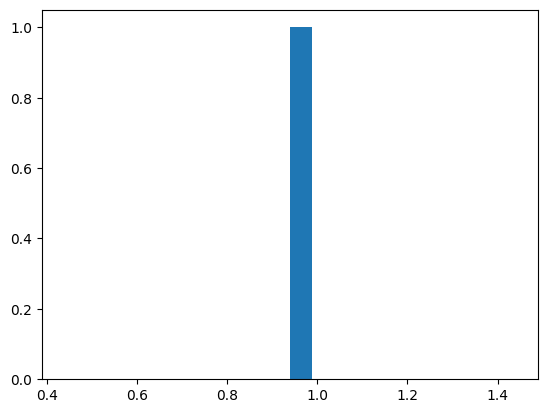

In [19]:
plt.figure(3)
for i in range(len(exponents)):
    if exponents[i] is None:
        exponents[i] = -1
plt.hist(exponents, bins=20)
